In [120]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Load Datasets


In [96]:
datafolder = "./datasets"

raw_data = []
volumes = []

# Read all csv files and append them in a list
for file in os.listdir(datafolder):
    volume_str, ext = file.split(".")
    if ext == "csv":
        volumes.append(volume_str.replace("_", ".").split("ml")[0])
        simple_df = pd.read_csv(os.path.join(datafolder, file),
                                names=["x_raw", "y_raw"],
                                decimal=",", delimiter=";")
        raw_data.append(simple_df)

In [97]:
# Sort the files depending on their name, related to the volume
volumes_float = [float(vol) for vol in volumes]
indices = np.argsort(volumes_float)
#np.array(volumes_float)[indices]

In [98]:
df = pd.concat(np.array(raw_data, dtype=object)[indices],
               keys=np.array(volumes_float)[indices])\
    .rename_axis(["volume", "id"])\
    .reset_index()
del df["id"]
df

,volume,x_raw,y_raw
0,0.0,-31.435066,31.556107
1,0.0,-31.100789,30.498769
2,0.0,-30.614569,29.815464
3,0.0,-30.249904,29.151295
4,0.0,-29.946017,28.416119
...,...,...,...
2116,27.0,31.108729,33.266380
2117,27.0,31.420994,33.769498
2118,27.0,31.777868,35.062518
2119,27.0,32.090134,35.593569


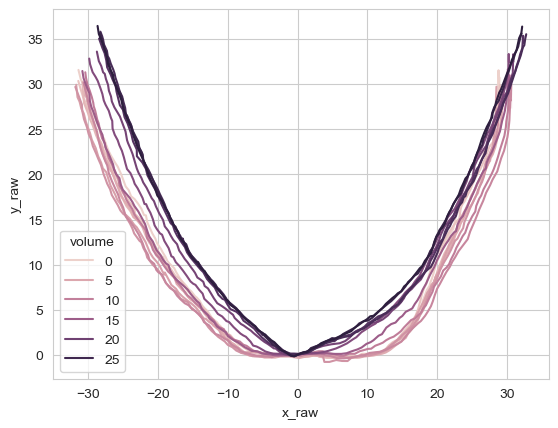

In [99]:
sns.lineplot(data=df, x="x_raw", y="y_raw", hue="volume")
plt.show()

## Pre-processing adjustments

In [100]:
df["x"] = df.groupby(["volume"])["x_raw"].apply(
    lambda x: 2 * (x - min(x)) / (max(x) - min(x)) - 1)
df["y"] = df.groupby(["volume"])["y_raw"].apply(
    lambda y: (y - max(y)) / (max(y) - min(y)))
df

,volume,x_raw,y_raw,x,y
0,0.0,-31.435066,31.556107,-1.000000,0.000000
1,0.0,-31.100789,30.498769,-0.988928,-0.033161
2,0.0,-30.614569,29.815464,-0.972823,-0.054592
3,0.0,-30.249904,29.151295,-0.960745,-0.075422
4,0.0,-29.946017,28.416119,-0.950679,-0.098479
...,...,...,...,...,...
2116,27.0,31.108729,33.266380,0.963484,-0.086339
2117,27.0,31.420994,33.769498,0.973737,-0.072580
2118,27.0,31.777868,35.062518,0.985454,-0.037216
2119,27.0,32.090134,35.593569,0.995706,-0.022693


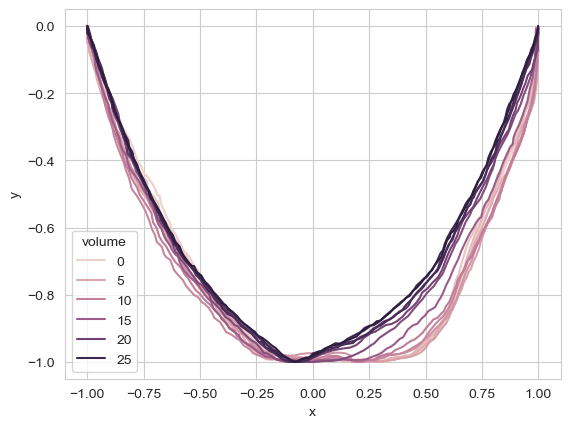

In [101]:
sns.lineplot(data=df, x="x", y="y", hue="volume")
plt.show()

## Fitting data

In [247]:
from scipy.optimize import curve_fit, differential_evolution, dual_annealing
from mittag_leffler import ml
import operator
from sklearn.metrics import mean_squared_error

Define the models

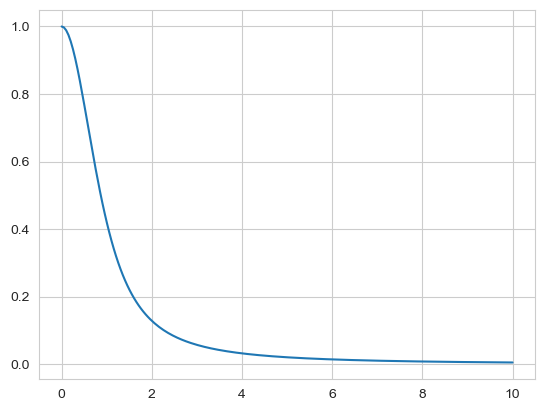

In [150]:
x = np.linspace(0, 10, 200)
y = np.vectorize(lambda xx: ml(xx, 0.55))(-np.power(x, 2))
plt.plot(x, y)
plt.show()

In [279]:
def ordinary_catenary(x_, a, x_0, y_0):
    return a * np.cosh(np.abs(x_ - x_0)/a) + y_0

def cuadratic(x_, a, b, x_0, y_0):
    return a * np.power(x_ - x_0, 2) + b * (x_ - x_0) + y_0

def cd_fract_catenary(x_, alpha, a, x_0, y_0):
    x_adj = (x_ - x_0) / a
    x_power_1 = np.power(x_adj.astype(complex), 1 + alpha)
    x_power_2 = np.power(x_adj.astype(complex), 2)
    #print(x_adj, alpha, x_power_1, x_power_2)
    return a * x_power_1.real * ml(x_power_2.real, 2, 2 + alpha) + y_0

Fit models

* Model ordinary_catenary:
- Function coefficients:
[ 0.63100148  0.04710872 -1.6541846 ]
- Covariance of coefficients:
[[ 3.24507144e-05  1.80251763e-06 -8.52151721e-06]
 [ 1.80251763e-06  8.40472352e-06 -1.41409819e-06]
 [-8.52151721e-06 -1.41409819e-06  1.67381801e-05]]

* Model cuadratic:
- Function coefficients:
[ 0.96023164 -0.57038447 -0.2446377  -0.96037998]
- Covariance of coefficients:
[[ 1.89867076e-04 -1.07592229e+03 -5.60240958e+02  3.19931287e+02]
 [-1.07592227e+03  4.26871029e+10  2.22275026e+10 -1.26932432e+10]
 [-5.60240951e+02  2.22275026e+10  1.15740314e+10 -6.60946928e+09]
 [ 3.19931283e+02 -1.26932432e+10 -6.60946928e+09  3.77440517e+09]]

* Model cd_fract_catenary:


/Users/jcrvz/.pyenv/versions/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)


differential_evolution step 1: f(x)= 0.00982556
differential_evolution step 2: f(x)= 0.00731164
differential_evolution step 3: f(x)= 0.00312942
differential_evolution step 4: f(x)= 0.00312942
differential_evolution step 5: f(x)= 0.00312942
differential_evolution step 6: f(x)= 0.0023926
differential_evolution step 7: f(x)= 0.00223906
differential_evolution step 8: f(x)= 0.00223906
differential_evolution step 9: f(x)= 0.00223906
differential_evolution step 10: f(x)= 0.00223906
differential_evolution step 11: f(x)= 0.00195698
differential_evolution step 12: f(x)= 0.00183777
differential_evolution step 13: f(x)= 0.00183777
differential_evolution step 14: f(x)= 0.00183777
differential_evolution step 15: f(x)= 0.00183777
differential_evolution step 16: f(x)= 0.00183187
differential_evolution step 17: f(x)= 0.0018171
differential_evolution step 18: f(x)= 0.00181686
differential_evolution step 19: f(x)= 0.00180278
differential_evolution step 20: f(x)= 0.00180205
differential_evolution step 21:

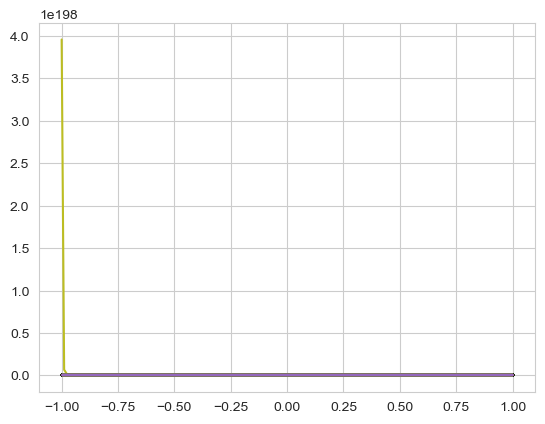

In [292]:
x = df.loc[df["volume"] == 0.0, "x"].to_numpy()
y = df.loc[df["volume"] == 0.0, "y"].to_numpy()
# Only for one value

x_new = np.linspace(-1, 1, 100)
df_models = pd.DataFrame({"x": x_new})

mse_models = dict()

for model in [ordinary_catenary, cuadratic, cd_fract_catenary]:
    print(f"* Model {model.__name__}:")

    if model == cd_fract_catenary:
        #         alpha   a     x_0      y_0
        bounds = [(0.8, 1.), (1e-6, 1.), (1e-6, 1.), (-2, 0.)]

        #x_values_ = x[x >= 0]
        #y_values_ = y[x >= 0]

        def obj_func(pp):
            params = list(pp)
            #y_predicted = [model(xx, *params) for xx in x]
            y_predicted = np.vectorize(lambda x_values: model(x_values, *params))(x)

            return mean_squared_error(y, y_predicted)

        result = differential_evolution(obj_func, bounds, strategy="currenttobest1bin", disp=True, popsize=30)
        #result = dual_annealing(obj_func, bounds)
        param, param_cov = result.x, None
        print(f"fitness: {result.fun} with {result.nfev} evaluations")
    else:
        param, param_cov = curve_fit(model, x, y)

    print("- Function coefficients:")
    print(param)
    print("- Covariance of coefficients:")
    print(param_cov)

    vmodel = np.vectorize(lambda pp: model(pp, *param))

    mse_models[model.__name__] = mean_squared_error(y, vmodel(x))

    df_models[model.__name__] = vmodel(x_new)
    print()

In [282]:
pp = [0.99, 1.2, 0.99, -0.22, -0.99]
params = list(pp)

for x_val in x:
    if x_val >= 0:
        y_predicted = model(x_val, *params)
        print(x_val, y_predicted)

#y_predicted = np.vectorize(lambda x_values: model(x_values, *params))(x)
#print(np.concatenate([x.T, y_predicted.T]))

#mean_squared_error(y, y_predicted)

TypeError: cd_fract_catenary() takes 5 positional arguments but 6 were given

In [293]:
print(*[f"{key}: {val:.2e}" for key, val in mse_models.items()], sep="\n")

ordinary_catenary: 2.10e-03
cuadratic: 2.35e-03
cd_fract_catenary: 1.72e-03


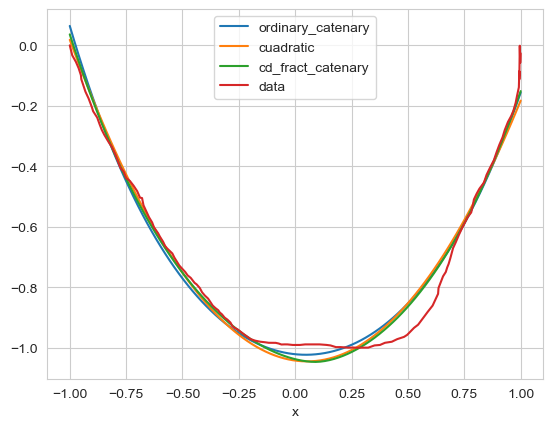

In [294]:
df_models.plot(x='x')
plt.plot(x, y, label="data")
plt.legend()
plt.show()